In [1]:
import math
import random
import copy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_points = len(lines)
    dim_points = 28 * 28
    data = np.empty((num_points, dim_points))
    labels = np.empty(num_points)
    
    for ind, line in enumerate(lines):
        num = line.split(',')
        labels[ind] = int(num[0])
        data[ind] = [ int(x) for x in num[1:] ]
        
    return (data, labels)

train_data, train_labels = read_data("sample_train.csv")
test_data, test_labels = read_data("sample_test.csv")
print(train_data.shape, test_data.shape)
print(train_labels.shape, test_labels.shape)

(6000, 784) (1000, 784)
(6000,) (1000,)


In [3]:
class DQN(nn.Module):
    def __init__(self, in_features):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=2)

    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.fc3(t)
        return t

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

    def __len__(self):
        return len(self.memory)

class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [4]:
class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x))

def train(model, optimizer, X, criterion=nn.NLLLoss()):
    epochs = 1
    batch_size = 64
    for e in range(epochs):
        running_loss = 0
        num_batches = 0
        order = np.copy(X)
        np.random.shuffle(order)
        i = 0
        while i < len(X):
            j = min(i + batch_size, len(X))
            images = train_data[order[i:j], :]
            labels = torch.Tensor(train_labels[order[i:j]]).long()
            optimizer.zero_grad()
            output = model(torch.from_numpy(images).float())
            loss = F.nll_loss(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_batches += 1
            i += batch_size

def predict(model):
    with torch.no_grad():
        output = model(torch.from_numpy(test_data).float())
    softmax = torch.exp(torch.Tensor(output))
    prob = softmax.numpy()
    predictions = np.argmax(prob, axis=1)
    return accuracy_score(test_labels, predictions)

In [5]:
batch_size = 64
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.0001
memory_size = 1000
num_episodes = 5
state_len = 10 + 784
budget = 1000
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
memory = ReplayMemory(memory_size)
dqnet = DQN(state_len)
target_dqnet = DQN(state_len)
target_dqnet.load_state_dict(dqnet.state_dict())
dqnet_optimizer = optim.Adam(dqnet.parameters(), lr=5e-3)
num_actions = 2
current_step = 0
target_update = 8

In [6]:
def dqn_train(model, target_model, optimizer, mini_batch):
    criterion = nn.MSELoss()
    optimizer.zero_grad()
    states = np.array([exp[0] for exp in mini_batch])
    actions = torch.Tensor([[exp[1]] for exp in mini_batch]).long()
    rewards = torch.Tensor([exp[2] for exp in mini_batch])
    next_states = torch.Tensor([exp[3] for exp in mini_batch])
    output = model(torch.from_numpy(states).float())
    predicted = torch.gather(output, 1, actions).squeeze()
    with torch.no_grad():
        labels_next = target_model(next_states).detach().max(1).values
    labels = rewards + gamma * labels_next
    loss = criterion(predicted, labels)
    loss.backward()
    optimizer.step()

def select_action(state, model, current_step):
    eps = strategy.get_exploration_rate(current_step)
    if random.random() < eps:
        return random.randrange(num_actions)
    else:
        with torch.no_grad():
            a = model(torch.from_numpy(state).float()).argmax().item()
        return a

In [7]:
order = list(range(0, train_data.shape[0]))
X_labelled = []
random.shuffle(order)
for _ in range(num_episodes):
    memory.memory.clear()
    i = 0
    model = Net(28 * 28)
    model_optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
    prev_acc = 0
    for j in range(train_data.shape[0]):
        sample = train_data[order[j]]
        part1 = np.copy(sample)
        with torch.no_grad():
            part2 = model(torch.from_numpy(sample).float()).detach().numpy()
            part2 = np.exp(part2)
            part2 = part2 / np.sum(part2)
        state = np.concatenate((part1, part2))
        
        a = select_action(state, dqnet, current_step)
        current_step += 1
        queried = False
        if a == 1:
            queried = True
            X_labelled.append(order[j])
            i += 1
            if i % 16 == 0:
                train(model, model_optimizer, X_labelled)
        if queried:
            acc = predict(model)
            r = acc - prev_acc
            prev_acc = acc
        else:
            r = 0
        if i == budget:
            X_labelled = []
            random.shuffle(order)
            sample = train_data[order[0]]
            part1 = np.copy(sample)
            with torch.no_grad():
                part2 = model(torch.from_numpy(sample).float()).detach().numpy()
                part2 = np.exp(part2)
                part2 = part2 / np.sum(part2)
            new_state = np.concatenate((part1, part2))
            memory.push(state, a, r, new_state)
            break
        
        sample = train_data[order[j + 1]]
        part1 = np.copy(sample)
        with torch.no_grad():
            part2 = model(torch.from_numpy(sample).float()).detach().numpy()
            part2 = np.exp(part2)
            part2 = part2 / np.sum(part2)
        new_state = np.concatenate((part1, part2))
        memory.push(state, a, r, new_state)
        if memory.can_provide_sample(batch_size):
            mini_batch = memory.sample(batch_size)
            dqn_train(dqnet, target_dqnet, dqnet_optimizer, mini_batch)
        if j % target_update == 0:
            target_dqnet.load_state_dict(dqnet.state_dict())
    if i < budget:
        X_labelled = []
        random.shuffle(order)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [8]:
train_data1, train_labels1 = read_data("sample_train.csv")
test_data1, test_labels1 = read_data("sample_test.csv")

In [43]:
def train1(model, optimizer, train_data1, train_labels1, plotdata):
    epochs = 1
    batch_size = 4
    for e in range(epochs):
        print(e)
        order = np.arange(train_data1.shape[0])
        np.random.shuffle(order)
        i = 0
        while i < train_data1.shape[0]:
            j = min(i + batch_size, train_data1.shape[0])
            images = train_data1[order[i:j], :]
            labels = torch.Tensor(train_labels1[order[i:j]]).long()
            optimizer.zero_grad()
            output = model(torch.from_numpy(images).float())
            prob = np.copy(output.detach().numpy())
            loss = F.nll_loss(output, labels)
            loss.backward()
            optimizer.step()
            i += batch_size
            with torch.no_grad():
                output = model(torch.from_numpy(test_data1).float())
            softmax = torch.exp(torch.Tensor(output))
            prob = list(softmax.numpy())
            predictions = np.argmax(prob, axis=1)
            if i % 300 == 0:
                plotdata.append([i + 1, accuracy_score(test_labels1, predictions)])
            
def train_AL(model, optimizer, train_data1, train_labels1, plotdata):
    epochs = 1
    for e in range(epochs):
        print(e)
        running_loss = 0
        num_batches = 0
        order = np.arange(train_data1.shape[0])
        np.random.shuffle(order)
        i = 0
        while i < train_data1.shape[0]:
            image = train_data1[order[i:i+1], :]
            part1 = np.copy(image[0])
            model.eval()
            with torch.no_grad():
                part2 = model(torch.from_numpy(image).float()).squeeze().detach().numpy()
            model.train()
            state = np.concatenate((part1, part2))
            a = select_action(state, dqnet, 1e9)
            if a == 1:
                label = torch.Tensor(train_labels1[order[i:i+1]]).long()
                optimizer.zero_grad()
                output = model(torch.from_numpy(image).float())
                prob = np.copy(output.detach().numpy())
                loss = F.nll_loss(output, label)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            i += 1
            with torch.no_grad():
                output = model2(torch.from_numpy(test_data1).float())
            softmax = torch.exp(torch.Tensor(output))
            prob = list(softmax.numpy())
            predictions = np.argmax(prob, axis=1)
            if i % 300 == 0:
                plotdata.append([i + 1, accuracy_score(test_labels1, predictions)])

def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_points = len(lines)
    dim_points = 28 * 28
    data = np.empty((num_points, dim_points))
    labels = np.empty(num_points)
    
    for ind, line in enumerate(lines):
        num = line.split(',')
        labels[ind] = int(num[0])
        data[ind] = [ int(x) for x in num[1:] ]
        
    return (data, labels)

In [44]:
model1 = Net(28 * 28)
model1_optimizer = optim.SGD(model1.parameters(), lr=1e-5, momentum=0.9)
D1 = []
train1(model1, model1_optimizer, train_data1, train_labels1, D1)

0


/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [45]:
model2 = Net(28 * 28)
model2_optimizer = optim.SGD(model2.parameters(), lr=1e-5, momentum=0.9)
D2 = []
train_AL(model2, model2_optimizer, train_data1, train_labels1, D2)

0


/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


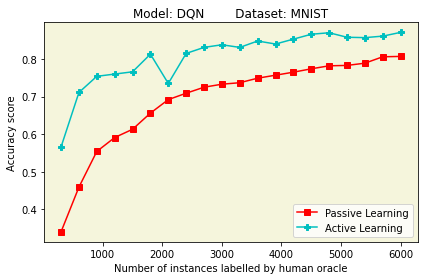

In [58]:
x1 = [item[0] for item in D1]
y1 = [item[1] for item in D1]
x2 = [item[0] for item in D2]
y2 = [item[1] for item in D2]
plt.plot(x1, y1, 'rs-', label='Passive Learning')
plt.plot(x2, y2, 'cP-', label='Active Learning')
plt.title('Model: DQN        Dataset: MNIST')
plt.xlabel('Number of instances labelled by human oracle')
plt.ylabel('Accuracy score')
plt.legend()
plt.tight_layout()
ax = plt.axes()
ax.set_facecolor('beige')
plt.savefig('plot.png')
plt.show()